In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import metrics

# Preparing Datasets

In [2]:
def load_dataset(fname):
    # read dataset
    dataset = pd.read_csv(fname, comment='#')

    # compositions to wt.%
    dataset.C *= 100
    dataset.Mn *= 100
    dataset.Si *= 100
    dataset.Cr *= 100
    dataset.Ni *= 100

    # temperatures to oC
    dataset.A1 -= 273.15
    dataset.A1prime -= 273.15
    dataset.A3 -= 273.15

    return dataset

In [3]:
def prepare_dataset(fname):
    raw_df = load_dataset(fname)
    
    
    if set(['file']).issubset(raw_df.columns):
        raw_df = raw_df.drop(['file'], axis=1)
    if set(['macro']).issubset(raw_df.columns):
        raw_df = raw_df.drop(['macro'], axis=1)
    
    df = raw_df.copy()

    '''
    Variables
    C, C**2, C*Mn, C*Si, C*Cr, C*Ni, 
    Mn, Mn**2, Mn*Si, Mn*Cr, Mn*Ni, 
    Si, Si*Si, Si*Cr, Si*Ni, 
    Cr, Cr**2, Cr*Ni,
    Ni, Ni**2]
    '''

    df['C2'] = df['C'].apply(lambda x: x**2)
    df['CMn'] = df['C'] * df['Mn']
    df['CSi'] = df['C'] * df['Si']
    df['CCr'] = df['C'] * df['Cr']
    df['CNi'] = df['C'] * df['Ni']
    df['Mn2'] = df['Mn'].apply(lambda x: x**2)
    df['MnSi'] = df['Si'] * df['Mn']
    df['MnCr'] = df['Cr'] * df['Mn']
    df['MnNi'] = df['Ni'] * df['Mn']
    df['Si'] = df['Si'].apply(lambda x: x**2)
    df['SiCr'] = df['Cr'] * df['Si']
    df['SiNi'] = df['Si'] * df['Ni']
    df['Cr2'] = df['Cr'].apply(lambda x: x**2)
    df['CrNi'] = df['Cr'] * df['Ni']
    df['Ni2'] = df['Ni'].apply(lambda x: x**2)

    df = df.drop(['A1', 'A1prime'], axis=1)
    is_na = df['A3'].isna() 
    df = df.loc[~is_na, :] #REMOVE ALL A3 NAN
    df['euct'] = (df['eutectoid'].map(lambda x: 1 if x == 'hiper' else 0))
    df= df.drop(['eutectoid'], axis=1) #REMOVE EUCTETOID COLLUMN BECAUSE IT'S A STRING
    
    return df

In [4]:
df_A3 = prepare_dataset('../../databases/Tcriticalcopy.csv')

hiper = df_A3['euct'] == 1
hipo = df_A3['euct'] == 0

df_hiper = df_A3.loc[hiper, :]
df_hipo = df_A3.loc[hipo, :]

In [5]:
df_random = prepare_dataset('../../databases/Tcritical_random_compositions_database.csv')

hiper = df_random['euct'] == 1
hipo = df_random['euct'] == 0
dfR_hiper = df_random.loc[hiper, :]
dfR_hipo = df_random.loc[hipo, :]

# A3 Testing Regression

In [6]:
def _split_between_train_and_test(df, size):
    #train size may be 0.8, 0.7 or 0.99
    target = df['A3']
    features = df.iloc[:, :20]
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        target,
        train_size=size,
        random_state=42
    )
    
    X_train = X_train.drop(['A3'], axis=1)
    X_test = X_test.drop(['A3'], axis=1)
    
    print('Train size: {}'.format(X_train.shape))
    #print('Test size: {}'.format(X_test.shape))
#     return X_train, y_train, X_test, y_test
    return X_train, y_train

## Hipoeutectoid

/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train size: (1842, 19)
Test size (404, 19)


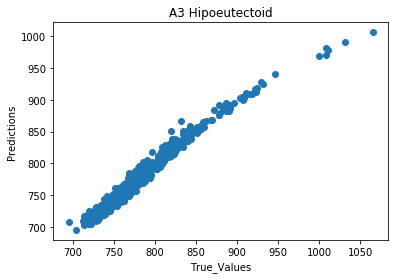

In [7]:
lm = linear_model.LinearRegression()

#Train
# Xh_train, yh_train, Xh_test, yh_test = _split_between_train_and_test(df_hipo, 0.8)
Xh_train, yh_train = _split_between_train_and_test(df_hipo, 0.8)
model_hipo = lm.fit(Xh_train, yh_train)

#Test
yh_test = dfR_hipo['A3']
Xh_test = dfR_hipo.copy().drop(['A3', 'euct'], axis=1)

print('Test size {}'.format(Xh_test.shape))

#Predict
predictions_h = lm.predict(Xh_test)

plt.scatter(yh_test, predictions_h)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A3 Hipoeutectoid')
plt.show()

#Xh_train

In [8]:
metrics.r2_score(yh_test, predictions_h)

0.9603487279483819

## Hipereutectoid

/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train size: (3633, 19)
Test size (404, 19)


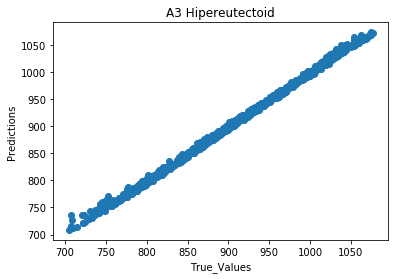

In [9]:
lm = linear_model.LinearRegression()

#Train
XH_train, yH_train = _split_between_train_and_test(df_hiper, 0.8)
model_hiper = lm.fit(XH_train, yH_train)

#Test
yH_test = dfR_hiper['A3']
XH_test = dfR_hiper.copy().drop(['A3', 'euct'], axis=1)

print('Test size {}'.format(Xh_test.shape))

#Predict
predictions_H = lm.predict(XH_test)

plt.scatter(yH_test, predictions_H)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A3 Hipereutectoid')
plt.show()

In [10]:
metrics.r2_score(yH_test, predictions_H)

0.9980969020321783

# Hipo & Hipereutectoid

/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train size: (1099, 19)
Test size (404, 19)


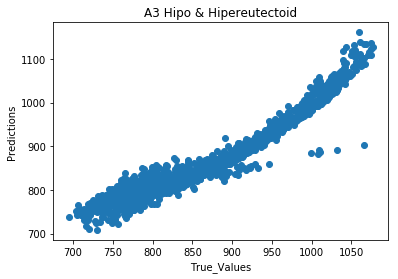

In [11]:
lm = linear_model.LinearRegression()

#Train
X_train, y_train = _split_between_train_and_test(df_random, 0.8)
model_all = lm.fit(X_train, y_train)

#Test
y_test = df_random['A3']
X_test = df_random.copy().drop(['A3', 'euct'], axis=1)

print('Test size {}'.format(Xh_test.shape))

#Predict
predictions_all = lm.predict(X_test)

plt.scatter(y_test, predictions_all)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A3 Hipo & Hipereutectoid')
plt.show()

In [12]:
metrics.r2_score(y_test, predictions_all)

0.920707459191059

# Summarizing...

r2 metrics

|  | Hipo | Hiper | All |
| --- | --- | --- | --- |
| original dataset|0.9607|0.9971| - |
| random dataset |0.9603|0.9981|0.9207|